In [ ]:
#| default_exp models

# Gradient Logger Models

> Modifying Keras' models to log the gradients during training.

In [ ]:
#| export
import tensorflow as tf
from tensorflow.keras import layers

from fastcore.basics import patch

The idea is to modify the base `train_step` to log the gradients as well as the other metrics during training.

We will need to be able to pair the weights with their gradients:

In [ ]:
#| exporti
# @patch
def _pair_grads(#self: Model,
                model, # Model used to calculate the gradients.
                gradients, # Calculated gradients.
                ):
    return {var.name: tf.norm(grad, 2) for var, grad in zip(model.trainable_variables, gradients)}

In [ ]:
#| export
class ModelGrad(tf.keras.Model):
    """Keras model that logs the gradients during training."""

    def __init__(self,
                 inputs, # Inputs to the model.
                 outputs, # Outputs of the model.
                 **kwargs, # Key-word arguments to be passed to `tf.keras.Model`.
                 ):
        super(ModelGrad, self).__init__(inputs=inputs, outputs=outputs, **kwargs)

    def build(self,
             input_shape,
             ):
        super(ModelGrad, self).build(input_shape)
        self._build_metrics()

    def train_step(self,
                   data, # Data to perform a train step on.
                   ):
        X, Y = data
        with tf.GradientTape() as tape:
            pred = self(X, training=True)
            loss = self.compiled_loss(Y, pred)
        gradients = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))
        paired_grads = _pair_grads(self, gradients)
        for m in self.grad_metrics:
            m.update_state(paired_grads[m.name[5:]])
        # Update metrics (includes the metric that tracks the loss)
        self.compiled_metrics.update_state(Y, pred)
        # Return a dict mapping metric names to current value
        return {m.name: m.result() for m in self.metrics}


    @property
    def metrics(self):
        metrics = []
        if self._is_compiled:
            if self.compiled_loss is not None:
                metrics += self.compiled_loss.metrics
            if self.compiled_metrics is not None:
                metrics += self.compiled_metrics.metrics

        for l in self._flatten_layers():
            metrics.extend(l._metrics)
        
        metrics.extend(self.grad_metrics)
        return metrics

    def _build_metrics(self):
        self.grad_metrics = [tf.keras.metrics.Mean(name="grad_"+var.name) for var in self.trainable_variables]

In [ ]:
def build_model(input_shape=(2,)):
    inputs = tf.keras.Input(input_shape)
    outputs = layers.Dense(10, input_shape=(2,))(inputs)
    outputs = layers.Dense(1)(outputs)
    return ModelGrad(inputs, outputs)

In [ ]:
model = build_model()
model.compile(loss="mse",
              optimizer="adam",
              )
model.build((None,2))
model.metrics

[<keras.metrics.base_metric.Mean>,
 <keras.metrics.base_metric.Mean>,
 <keras.metrics.base_metric.Mean>,
 <keras.metrics.base_metric.Mean>,
 <keras.metrics.base_metric.Mean>,
 <keras.metrics.base_metric.Mean>,
 <keras.metrics.base_metric.Mean>,
 <keras.metrics.base_metric.Mean>]

In [ ]:
X_train = tf.random.uniform(shape=(32,2))
Y_train = tf.random.uniform(shape=(32,))

In [ ]:
model.train_step((X_train, Y_train))

{'loss': <tf.Tensor: shape=(), dtype=float32, numpy=0.41568166>,
 'grad_dense_39/kernel:0': <tf.Tensor: shape=(), dtype=float32, numpy=1.0007985>,
 'grad_dense_39/bias:0': <tf.Tensor: shape=(), dtype=float32, numpy=1.0947292>,
 'grad_dense_40/kernel:0': <tf.Tensor: shape=(), dtype=float32, numpy=0.8182423>,
 'grad_dense_40/bias:0': <tf.Tensor: shape=(), dtype=float32, numpy=0.7366093>}

## Actual training example

In [ ]:
from tensorflow.keras.datasets import mnist

In [ ]:
(X_train, Y_train), (X_test, Y_test) = mnist.load_data()

X_train = X_train[:,:,:,None]/255.0
X_test = X_test[:,:,:,None]/255.0

In [ ]:
def build_model(input_shape):
    inputs = tf.keras.Input(input_shape)
    outputs = layers.Conv2D(32, 3, activation="relu")(inputs)
    outputs = layers.MaxPool2D(2)(outputs)
    outputs = layers.Conv2D(32, 3, activation="relu")(outputs)
    outputs = layers.GlobalAveragePooling2D()(outputs)
    outputs = layers.Dense(10, activation="softmax")(outputs)
    return ModelGrad(inputs, outputs)

In [ ]:
model = build_model(input_shape=X_train[0].shape)
model.build((None, *X_train[0].shape))
model.compile(optimizer="adam",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])
model.summary()

Model: "model_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_20 (InputLayer)       [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_7 (Conv2D)           (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 13, 13, 32)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 11, 11, 32)        9248      
                                                                 
 global_average_pooling2d_3   (None, 32)               0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_41 (Dense)            (None, 10)                330

In [ ]:
history = model.fit(X_train, Y_train, epochs=2, batch_size=128, validation_split=0.2)

Epoch 1/2
  1/375 [..............................] - ETA: 2:39 - loss: 2.3055 - accuracy: 0.0938 - grad_conv2d_7/kernel:0: 0.0580 - grad_conv2d_7/bias:0: 0.0392 - grad_conv2d_8/kernel:0: 0.0784 - grad_conv2d_8/bias:0: 0.0696 - grad_dense_41/kernel:0: 0.0226 - grad_dense_41/bias:0: 0.1117

2023-01-27 21:29:18.147794: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


375/375 [==============================] - ETA: 0s - loss: 1.7997 - accuracy: 0.3921 - grad_conv2d_7/kernel:0: 0.2701 - grad_conv2d_7/bias:0: 0.3519 - grad_conv2d_8/kernel:0: 0.3392 - grad_conv2d_8/bias:0: 0.0847 - grad_dense_41/kernel:0: 0.6249 - grad_dense_41/bias:0: 0.0894

2023-01-27 21:29:22.397157: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


375/375 [==============================] - 5s 12ms/step - loss: 1.7997 - accuracy: 0.3921 - grad_conv2d_7/kernel:0: 0.2701 - grad_conv2d_7/bias:0: 0.3519 - grad_conv2d_8/kernel:0: 0.3392 - grad_conv2d_8/bias:0: 0.0847 - grad_dense_41/kernel:0: 0.6249 - grad_dense_41/bias:0: 0.0894 - val_loss: 1.2297 - val_accuracy: 0.6573 - val_grad_conv2d_7/kernel:0: 0.0000e+00 - val_grad_conv2d_7/bias:0: 0.0000e+00 - val_grad_conv2d_8/kernel:0: 0.0000e+00 - val_grad_conv2d_8/bias:0: 0.0000e+00 - val_grad_dense_41/kernel:0: 0.0000e+00 - val_grad_dense_41/bias:0: 0.0000e+00
Epoch 2/2
375/375 [==============================] - 4s 11ms/step - loss: 0.9969 - accuracy: 0.7050 - grad_conv2d_7/kernel:0: 0.3838 - grad_conv2d_7/bias:0: 0.6641 - grad_conv2d_8/kernel:0: 0.7450 - grad_conv2d_8/bias:0: 0.0759 - grad_dense_41/kernel:0: 1.7635 - grad_dense_41/bias:0: 0.0737 - val_loss: 0.7965 - val_accuracy: 0.7711 - val_grad_conv2d_7/kernel:0: 0.0000e+00 - val_grad_conv2d_7/bias:0: 0.0000e+00 - val_grad_conv2d_8/ke

In [ ]:
import matplotlib.pyplot as plt

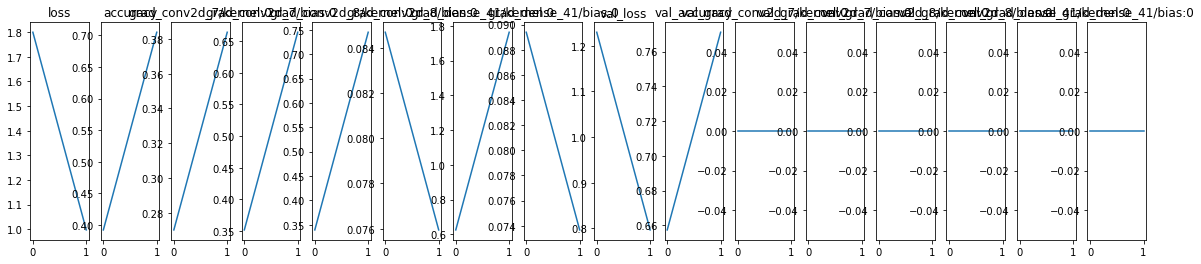

In [ ]:
fig, axes = plt.subplots(1, len(history.history.keys()), figsize=(20,4))
for ax, (name, values) in zip(axes.ravel(), history.history.items()): 
    ax.plot(values)
    ax.set_title(name)
plt.show()